# Libraries

In [1]:
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

from PIL import Image
from PIL import ImageFile
from skimage import io
from skimage.transform import rescale
from skimage.transform import resize


from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier # Pour instancier et entraîner un modèle Random Forest
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix # Pour les performances de classification

# Variables

## Paths

In [2]:
root_dir ='C:/Users/thibe/Google Drive/Projet datascientest/'
raw_data_dir = root_dir + 'RAW DATA/'
images_dir = raw_data_dir + 'IMAGES/'
json_dir = raw_data_dir + 'JSON/'
ML_dir = root_dir + 'ML/'

## Other

In [3]:
# seed 
random_seed = 42

# resize param :
pix_rows,pix_cols = 36 , 48

# build csv 
loop_over_images = True

debug = False
# slice des listes 
idx_max = 10  if debug else None 
# reduce number of year
range_years = range(2006,2008) if debug else range(2006,2017)

# Load & filter dataset EDA

In [4]:
df =  pd.read_csv(root_dir + 'image_and_json_data.csv')

C:\Users\thibe\.conda\envs\Mush\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (6,9,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
#select only 320,240 images with family info
df = df[df['resolution']=='(320, 240)'] 
# drop na 
df = df[df['gbif_info.family'].notna()]
# df.isna().sum()

In [6]:
# keep conf level over 90 
df = df.loc[df['gbif_info.confidence']>90]

In [7]:
# keep top families only 
top = list(df['gbif_info.family'].value_counts().index.values)[:10]
df = df.loc[df['gbif_info.family'].isin(top)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43608 entries, 5 to 214980
Data columns (total 38 columns):
file_name                   43608 non-null object
file_path                   43608 non-null object
resolution                  43608 non-null object
file_year                   43608 non-null int64
image_id                    43608 non-null int64
format                      43608 non-null object
observation                 43608 non-null object
label                       43608 non-null object
image_url                   43608 non-null object
user                        43608 non-null object
date                        43608 non-null object
thumbnail                   43608 non-null int64
location                    43608 non-null object
gbif_info.kingdom           43608 non-null object
gbif_info.family            43608 non-null object
gbif_info.speciesKey        30809 non-null float64
gbif_info.rank              43608 non-null object
gbif_info.phylum            43608 non-null

In [8]:
summary = df.copy() #copy for later 

# Buil dataset for ML 

## Loop on images to build csv

In [9]:
# passer par des array + format numpy quand on aura décider du dataset (devrait permettre d'augmenter la résolution)

In [10]:
if loop_over_images:
    years = range_years  # df['file_year'].unique().tolist()

    # loop to get a csv per year 
    for year in years :
        print('processing files from {}'.format(year))
        # filter on year 
        df_=df[df['file_year']==year]
        # generate lists
        img_path_lst = df_['file_path'].tolist()[:idx_max]
        img_id_lst = df_['image_id'].tolist()[:idx_max]
        family_lst = df_['gbif_info.family'].tolist()[:idx_max]
        # initiate two dicts 
        img_dict_ = {}
        family_dict_ = {}
        # define csv 
        feat_csv_path = ML_dir + 'images_' + str(year) + '.csv' # define path
        y_csv_path = ML_dir + 'y_' + str(year) + '.csv' # define path
        # loop to get a dict of array & a dict for y 
        for img_id,path,family in tqdm(zip(img_id_lst,img_path_lst,family_lst)): 
            img = io.imread(path) 
            img = resize(img, (pix_rows, pix_cols))  # RESIZE usng skimage    
    #         img = Image.open(path) 
    #         img.thumbnail((pix_cols,pix_rows)) # RESIZE usng opencv (/!\ size param inversé)
            img_arr = np.array(img) # convert to array 
            img_dict_[img_id] = np.resize(img_arr,pix_rows*pix_cols*3)
            # target 
            family_dict_[img_id] = family
        # conncat dict in df
        df_X = pd.DataFrame.from_dict(img_dict_, orient = 'index')
        df_y = pd.DataFrame.from_dict(family_dict_, orient = 'index')
        # save file
        df_X.to_csv(feat_csv_path)
        df_y.to_csv(y_csv_path)

1it [00:00,  9.76it/s]

processing files from 2006


78it [00:01, 49.12it/s]


KeyboardInterrupt: 

## Load csv

In [11]:
# Load csv features
csv_files = [ ML_dir + 'images_' + str(year) + '.csv' for year in range_years if os.path.exists(ML_dir + 'images_' + str(year) + '.csv')]
dfs_ = []
for filename in csv_files:
  df_ = pd.read_csv(filename, index_col=0, dtype=float)
  dfs_.append(df_)
df_X = pd.concat(dfs_, axis=0)
df_X.head(2)

,0,1,2,3,4,5,6,7,8,9,...,5174,5175,5176,5177,5178,5179,5180,5181,5182,5183
682.0,0.088235,0.085512,0.068627,0.161438,0.143464,0.119935,0.126035,0.113072,0.078431,0.160022,...,0.175926,0.326144,0.239216,0.156863,0.316013,0.232026,0.163725,0.328758,0.243791,0.168083
685.0,0.066667,0.093464,0.050327,0.086601,0.112418,0.035621,0.081046,0.089542,0.051525,0.101089,...,0.152179,0.250436,0.257407,0.163508,0.210784,0.260131,0.136601,0.162092,0.204031,0.090850


In [12]:
# Load csv y
csv_files = [ ML_dir + 'y_' + str(year) + '.csv' for year in range_years if os.path.exists(ML_dir + 'y_' + str(year) + '.csv')]
dfs_ = []
for filename in csv_files:
  df_ = pd.read_csv(filename, index_col=0)
  dfs_.append(df_)
df_y = pd.concat(dfs_, axis=0)
df_y.head(2)

,0
682,Agaricaceae
685,Agaricaceae


## Check images

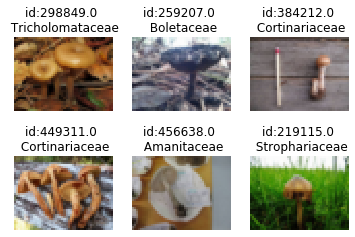

In [13]:
j = 1
image_ids = []
for i in range(6):
    # image_id  
    image_id = random.choice(df_X.index)
    image_ids.append(image_id) #pour retrouver les paths apres 
    # TARGET
    target = df_y.loc[image_id].values[0]
    # Image
    img = df_X.loc[image_id,:].to_numpy().reshape(pix_rows, pix_cols, 3)
    # Subplot nous permet de selectionner une des sous-figures parmi une grille. Dans notre cas la grille
    # a 2 lignes et 3 colonnes.
    plt.subplot(2, 3, j)
    j = j + 1   
    # Suppresion des axes
    plt.axis('off')  
    # Affichage de la figure en niveaux de gris
    plt.imshow(img)
    # Modification du titre de la figure
    plt.title('id:{} \n {}'.format(str(image_id),target))

In [14]:
# to check with raw files 
for image_id in image_ids:
     print(str(summary.loc[summary['image_id'] == image_id,'file_path'].values[0]).replace('/',os.sep).replace('\\\\',os.sep) + 
           '-'*10 + '>' +
          str(summary.loc[summary['image_id'] == image_id,'gbif_info.family'].values[0]))

C:\Users\thibe\Google Drive\Projet datascientest\RAW DATA\IMAGES\2012\Clitocybe\298849.jpg---------->Tricholomataceae
C:\Users\thibe\Google Drive\Projet datascientest\RAW DATA\IMAGES\2012\Strobilomyces strobilaceus\259207.jpg---------->Boletaceae
C:\Users\thibe\Google Drive\Projet datascientest\RAW DATA\IMAGES\2013\Cortinarius\384212.jpg---------->Cortinariaceae
C:\Users\thibe\Google Drive\Projet datascientest\RAW DATA\IMAGES\2014\Cortinarius limonius\449311.jpg---------->Cortinariaceae
C:\Users\thibe\Google Drive\Projet datascientest\RAW DATA\IMAGES\2014\Amanita tephrea\456638.jpg---------->Amanitaceae
C:\Users\thibe\Google Drive\Projet datascientest\RAW DATA\IMAGES\2012\Psilocybe baeocystis\219115.jpg---------->Strophariaceae


## Save as array

In [15]:
#convert to numpy array 
X=df_X.to_numpy()
y=df_y.to_numpy()
# save 
np.save(ML_dir + 'X', X)
np.save(ML_dir + 'y', y)

# Random forest 

In [16]:
# AJOUTER LOAD X, y directement ici une fois qu'on aura fixer le dataset

In [17]:
## Convert y
le = preprocessing.LabelEncoder()
y = le.fit_transform(y.ravel())
y

array([0, 0, 0, ..., 2, 2, 2])

In [18]:
## train / test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

In [19]:
# train model 
# Instanciation d'un modele Random Forest
model = RandomForestClassifier(n_jobs=-2)
# Entraînement du modèle
model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-2)

In [20]:
# Prédiction sur l'échantillon de test
test_pred = model.predict(X_test)

In [21]:
print("Evaluation détaillée de la Classification par RDF :\n \n" ,
      (classification_report(y_test, test_pred)))

# On observe que les chiffres 0, 1 et 6 ont le meilleur rappel (recall), tandis que le chiffre 1 a la meilleure précision.
# Le F1-score, qui calcule la moyenne harmonique de la précision et du rappel, est un bon indicateur lorsqu'on cherche à prendre
# en compte ces deux mesures.

Evaluation détaillée de la Classification par RDF :
 
               precision    recall  f1-score   support

           0       0.25      0.31      0.28      1095
           1       0.24      0.21      0.22      1004
           2       0.21      0.48      0.29      1174
           3       0.15      0.11      0.12       792
           4       0.45      0.05      0.09       487
           5       0.20      0.02      0.03       535
           6       0.15      0.00      0.01       511
           7       0.22      0.34      0.27      1207
           8       0.22      0.14      0.17       917
           9       0.20      0.14      0.16       997

    accuracy                           0.22      8719
   macro avg       0.23      0.18      0.16      8719
weighted avg       0.22      0.22      0.19      8719

